In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
#for xgboost model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
#for checking xgboost model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Monte Carlo Simulation

This is the start of the file where I will put together my volatility modeling from before and compare its performance with volatilities used by traditional pricing models. The models I will be looking at are:
- black sholes with a constant volatility
- heston with a stochastically calculated volatility
- monte carlo simulation with black sholes to utilize my own modeled volatility
- maybe hull-white with stochastically calculated volatility

We will first get the data we need from the stock set of 18 stock's closing prices over the past 10 years.

In [3]:
#Stock data preparation
# gather data
stockgrp = pd.read_excel("10yrClosingPricesStocks.xlsx")
stockgrp = stockgrp.drop(columns=['Date'])

#calculate log returns then volatility
returns = np.log(stockgrp / stockgrp.shift(1))
volatility = returns.rolling(window=20).std() * np.sqrt(252)
volatility = volatility.dropna()

#we will work with the average of our 18 stocks to fit a marketwide view
avg_volatility = volatility.mean(axis=1) 
avg_volatility = avg_volatility.to_frame()
avg_volatility.columns = ['volatility']

#if we want to see the full dataset
def plot_avg(data):
    plt.figure(figsize=(10,5))
    plt.plot(data, label="Average Volatility", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.title("Market-Wide Average Volatility")
    plt.legend()
    plt.show()
#plot_avg(avg_volatility.tail(500))

Here we move into some preprocessing of the data - splitting it up and getting it ready for the monte carlo simulations.

Also we will run and train our data on the xgboost model, which is the model that performed the best to predict volatility.
The volatility data that we are predicting will only be used for one of the monte carlo simulations, which we will get to eventually.

In [22]:
#What we will actually need is the stock price on the first day of the test set - day 2001(roughly) or 1st day of test set
# we will also need the test data
# finally we will need the data we predicted based off the xgboost model, which we will import in
#so to do this we will need to repeat our creation of the xgboost model along with the preprocessing we did to the data before we ran the model
#Starting off with the lagged features function which shifts the data by a certain number of days
def create_lagged_features(data, lag=30):
    df = pd.DataFrame(data, columns=['volatility'])
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['volatility'].shift(i)
    df.dropna(inplace=True)
    return df

lag = 30 #number of lagged days
data = create_lagged_features(avg_volatility, lag=lag)
#split into features and target
X = data.drop(columns=['volatility']).values
y = data['volatility'].values

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#now the model training
#Now our data is ready and we can actually build our XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100, #number of trees
    learning_rate=0.1, #step size shrinkage
    max_depth=5, #max depth of a tree
    subsample=0.8, #fraction of samples used for training each tree
    colsample_bytree=0.8, #Fraction of features used for training each tree
    random_state=42
)
#train the model
xgb_model.fit(X_train, y_train)
#make predictions
xgb_predictions = xgb_model.predict(X_test)

def xgb_visualize():
    #start with metrics
    rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    mae = mean_absolute_error(y_test, xgb_predictions)
    r2 = r2_score(y_test, xgb_predictions)
    print(f"XGBoost RMSE: {rmse}")
    print(f"XGBoost MAE: {mae}")
    print(f"XGBoost R²: {r2}")

    #now plot actual v predicted
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(xgb_predictions, label='Predicted', color='orange')
    plt.title('Actual vs Predicted Volatility (XGBoost)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
#if we want to see the xgbmodel we can uncomment the below function call - to check if the model is working properly
#xgb_visualize()

#so our data we will use from here is:
# 1st element of stockgrp on day 1998(1st day of test set) will be the stock price
# the average of y_train will be sigma or our constant volatility
# for the enhanced bs model we will need the predicted data to plug into the volatility

In [11]:
#stock price param will be the same for every simulation
stock_price = np.mean(stockgrp.iloc[2047])  #day 1 price of our stock's averaged

#also the below are used in every single simulation's plotting section and will be the same/only need to be calcualted once
# Actual test path (avg of 18 stocks from day 2000 to end)
actual_path = stockgrp.iloc[2047:].mean(axis=1).values
# Actual final day prices of the 18 stocks
actual_final_price = actual_path[-1]
#actual log returns on the final day
actual_log_return = np.log(actual_final_price / stock_price)
print(f"day 1: ${stock_price:.2f}")

day 1: $95.90


Now, we will perform the actual Monte Carlo simulation - derived from the Black-Scholes model.
This one will use a constant volatility that we will get by taking the average of the historical volatility training data, so first 2000 days of the data.

In [13]:
#Black Scholes with constant volatility from training set - past data
#simulated with a monte carlo simulation

#start with initial parameters
sigma = np.mean(y_train) #averaged out volatility from the training data - black-scholes doesnt know our test data
mu = .03    #risk free rate - standard rate

#time params
T = 2   #time horizon in years
num_simulations = 50000 #number of simulations or runs of the monte carlo    
num_steps = 500   #number of steps, but also just number of days in the datasets
dt = T/num_steps    #dt plugs into formula
#now for the simulations
#simulate paths
price_paths = np.zeros((num_simulations, num_steps))
price_paths[:,0] = stock_price

#simulate paths using GBM formula
for t in range(1, num_steps):
    z = np.random.standard_normal(num_simulations)  #add in random shocks based on normal distribution - weiner process
    #now our actual Geometric Brownian Motion equation derived from black-scholes
    #we also disctretize the equation to make it applicable to a monte carlo simulation
    price_paths[:, t] = price_paths[:, t-1] * np.exp((mu - 0.5 *(sigma**2)) * dt + sigma * np.sqrt(dt) * z)

#final results
final_prices = price_paths[:, -1]   #final path to be simulated
log_returns = np.log(final_prices / stock_price)    #returns calculated from those prices

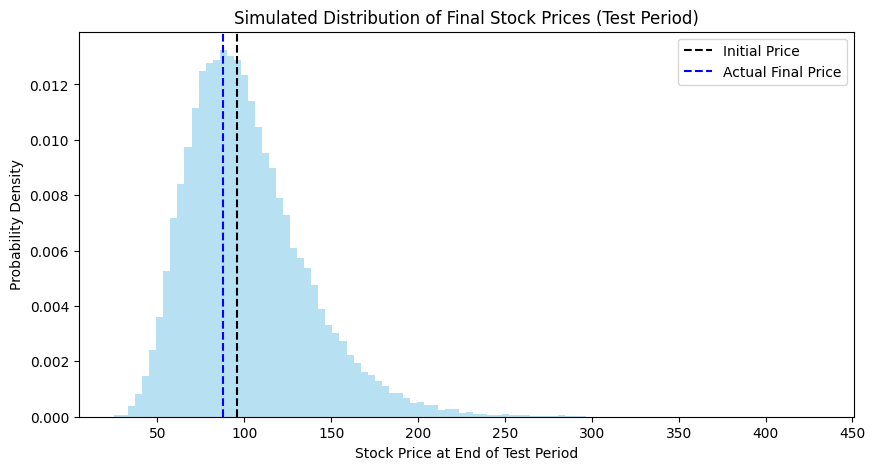

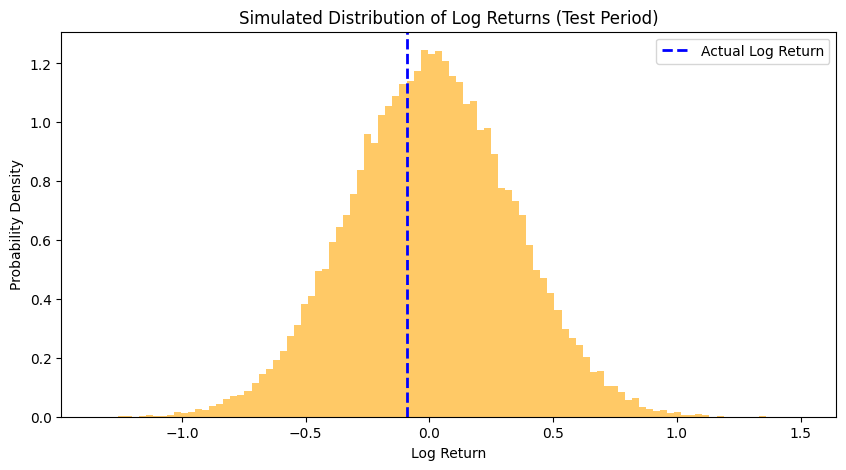

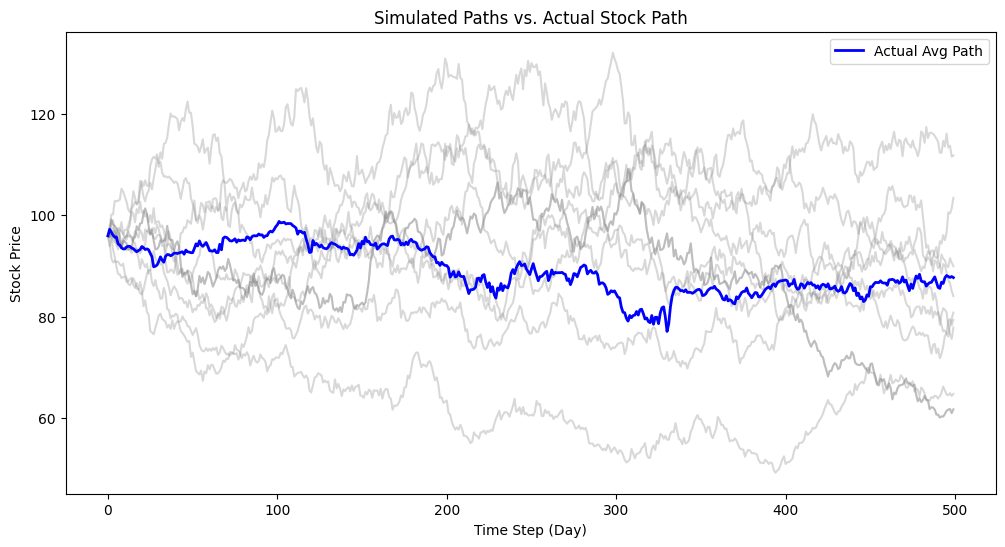

87.6756
101.86171245159963
Mean Absolute Error: 14.186112451599627


In [14]:
#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.axvline(actual_final_price, color='blue', linestyle='--', label='Actual Final Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.axvline(actual_log_return, color='blue', linestyle='--', linewidth=2, label='Actual Log Return')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Plot a few simulated paths
plt.figure(figsize=(12,6))
for i in range(10):  # plot 10 simulations
    rand_num = np.random.randint(low=1,high=500)
    plt.plot(price_paths[-rand_num], color='gray', alpha=0.3)

plt.plot(actual_path, color='blue', linewidth=2, label='Actual Avg Path')
#plt.plot(price_paths[-1], color='orange', linewidth=2, label='Final Price Path')
plt.title("Simulated Paths vs. Actual Stock Path")
plt.xlabel("Time Step (Day)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#get some metrics to compare closer
#find error of each model between actual data's final price and simulated data's average of the final prices
mae = np.abs(actual_final_price - np.mean(final_prices))
print(actual_final_price)
print(np.mean(final_prices))
print(f"Mean Absolute Error: {mae}")

Here is where I will use a monte carlo simulation again with Black-scholes, but this time I will input my volatility that I predicted using XGboost rather than keeping volatility constant. I predicted volatility over the 500 day testing period, so I can input that right into the model and see how that improves it.

In [23]:
#Black Scholes with my machine learning predicted volatility

#start with initial parameters
predicted_vols = xgb_predictions #we can input the predicted volatility right into the simulation and the black-scholes formula
mu = .03    #risk free rate - standard rate

#time params
T = 2   #time horizon in years
num_simulations = 10000 #number of simulations or runs of the monte carlo    
num_steps = 500   #number of steps, but also just number of days in the datasets
dt = T/num_steps    #dt plugs into formula

#now for the simulations
#simulate paths
price_paths = np.zeros((num_simulations, num_steps))
price_paths[:,0] = stock_price

#simulate paths using GBM formula
for t in range(1, num_steps):
    sigma_t = predicted_vols[t]
    z = np.random.standard_normal(num_simulations)  #add in random shocks based on normal distribution - weiner process
    #now our actual Geometric Brownian Motion equation derived from black-scholes
    #we also disctretize the equation to make it applicable to a monte carlo simulation
    price_paths[:, t] = price_paths[:, t-1] * np.exp((mu - 0.5 *(sigma_t**2)) * dt + sigma_t * np.sqrt(dt) * z)

#final results
final_prices = price_paths[:, -1]   #final path to be simulated
log_returns = np.log(final_prices / stock_price)    #returns calculated from those prices

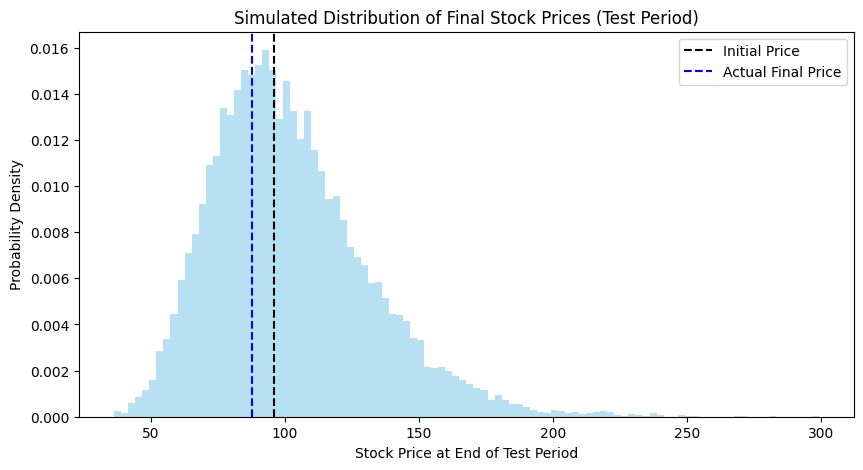

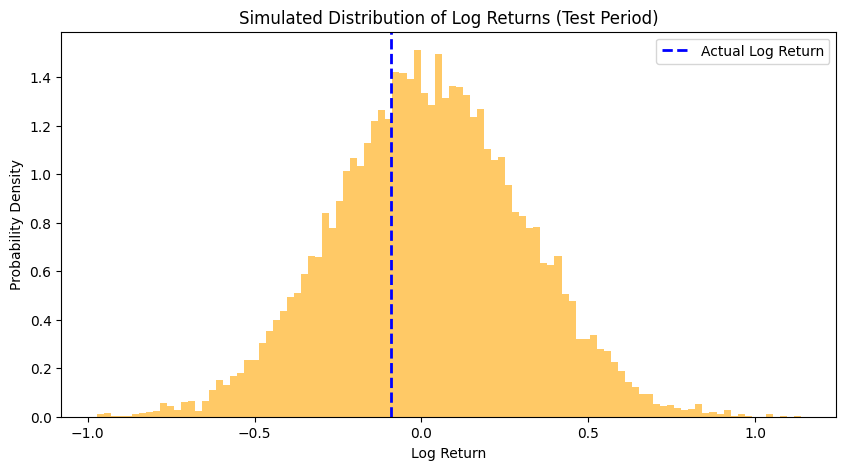

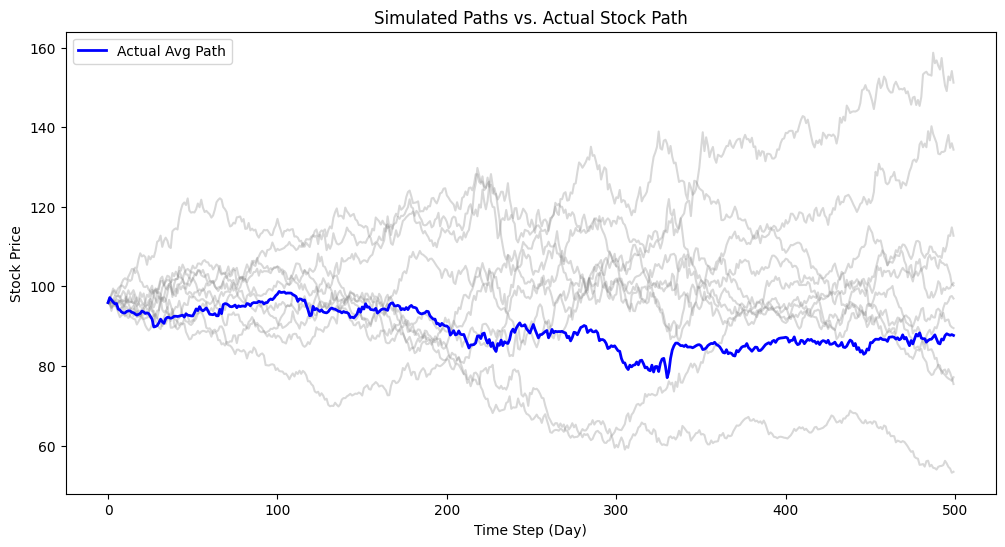

Mean Absolute Error: 14.405931475404529


In [16]:
#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.axvline(actual_final_price, color='blue', linestyle='--', label='Actual Final Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.axvline(actual_log_return, color='blue', linestyle='--', linewidth=2, label='Actual Log Return')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Plot a few simulated paths
plt.figure(figsize=(12,6))
for i in range(10):  # plot 10 simulations
    rand_num = np.random.randint(low=1,high=500)
    plt.plot(price_paths[-rand_num], color='gray', alpha=0.3)

plt.plot(actual_path, color='blue', linewidth=2, label='Actual Avg Path')
plt.title("Simulated Paths vs. Actual Stock Path")
plt.xlabel("Time Step (Day)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#get some metrics to compare closer
#find error of each model between actual data's final price and simulated data's average of the final prices
mae = np.abs(actual_final_price - np.mean(final_prices))
print(f"Mean Absolute Error: {mae}")

Now, we will move on to a monte carlo simulation with the Heston model. This model is slightly different then Black-Scholes because instead of using a constant volatility it uses a stochastically generated volatility that changes over time. We will now implement this below.

In [17]:
#Heston with stochastically changing volatility with data from training set of historical volatility

#start with initial parameters
sigma = np.mean(y_train) #averaged out volatility from training data - also same as black-scholes
mu = .03    #risk free rate - standard rate

#new for Heston model - check these again to make sure they are right
kappa = 2.0 #speed of mean reversion
theta = sigma**2    #long-run variance (use avg training variance)
xi = 0.2    #vol of vol
rho = -0.7  #correlation between price 
V0 = sigma**2   #initial variance from training data

#time params
T = 2   #time horizon in years
num_simulations = 20000 #number of simulations or runs of the monte carlo    
num_steps = 500   #number of steps, but also just number of days in the datasets
dt = T/num_steps    #dt plugs into formula

#initialize arrays
S = np.zeros((num_simulations, num_steps))
V = np.zeros((num_simulations, num_steps))
S[:,0] = stock_price
V[:,0] = V0

#simulate paths using GBM formula
for t in range(1, num_steps):
    #weiner process - unocrrelated random shocks from normal distribution
    z1 = np.random.standard_normal(num_simulations) 
    z2 = np.random.standard_normal(num_simulations)
    #generate correlated brownian motions
    dw1 = z1 * np.sqrt(dt)
    dw2 = (rho * z1 + np.sqrt(1- rho**2) * z2) * np.sqrt(dt)

    #now put Heston's formula to work - discretized versions of his stochastic formulas that are suitable for Monte Carlo Sim
    #also will be using full truncation euler scheme to ensure V >= 0
    V[:, t] = np.abs(V[:, t-1] + kappa * (theta - V[:, t-1]) * dt + xi * np.sqrt(np.maximum(V[:, t-1], 0)) * dw2)
    
    S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * V[:, t-1]) * dt + np.sqrt(np.maximum(V[:, t-1], 0)) * dw1)

#final results
final_prices = S[:, -1]   #final path to be simulated
log_returns = np.log(final_prices / stock_price)    #returns calculated from those prices

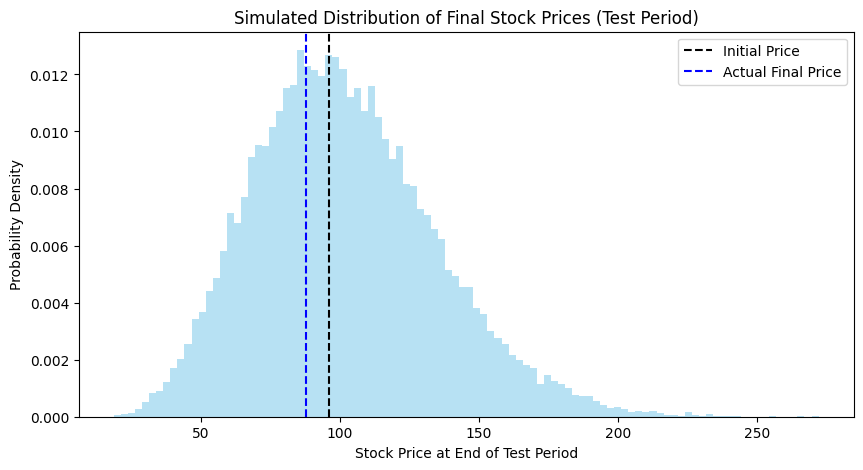

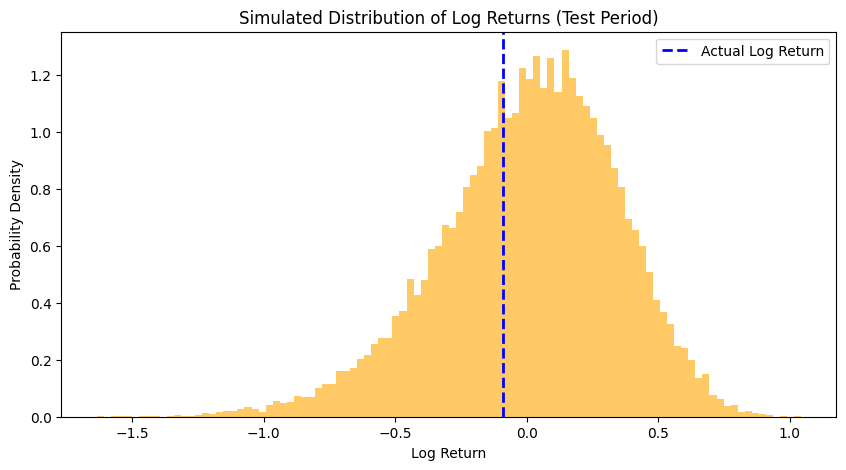

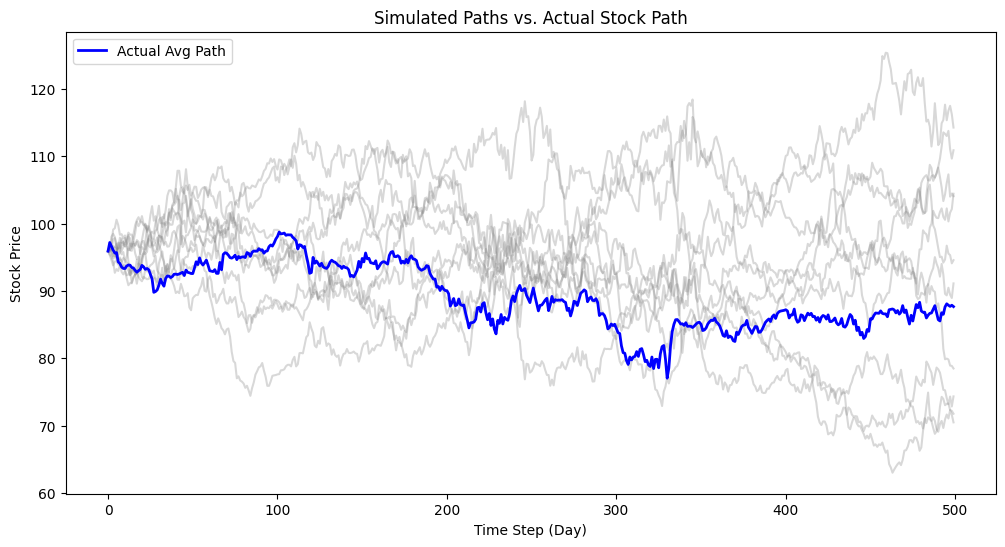

Mean Absolute Error: 14.266125841595652


In [18]:
#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.axvline(actual_final_price, color='blue', linestyle='--', label='Actual Final Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.axvline(actual_log_return, color='blue', linestyle='--', linewidth=2, label='Actual Log Return')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Plot a few simulated paths
plt.figure(figsize=(12,6))
for i in range(10):  # plot 10 simulations
    rand_num = np.random.randint(low=1,high=500)
    plt.plot(price_paths[-rand_num], color='gray', alpha=0.3)

plt.plot(actual_path, color='blue', linewidth=2, label='Actual Avg Path')
plt.title("Simulated Paths vs. Actual Stock Path")
plt.xlabel("Time Step (Day)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#get some metrics to compare closer
#find error of each model between actual data's final price and simulated data's average of the final prices
mae = np.abs(actual_final_price - np.mean(final_prices))
print(f"Mean Absolute Error: {mae}")

Now, we will move onto the Hull-White model, which is similar to the Heston model in that it changes volatility over time using stochastic calculus. It should not be too many changes, but it will be another good comparison to add.

In [19]:
#Hull-White with stochastically changing volatility with data from training set of historical volatility

#start with initial parameters
sigma = np.mean(y_train) #averaged out volatility from training data - also same as black-scholes and heston
mu = .03    #risk free rate - standard rate

#new for Heston model - check these again to make sure they are right
phi = 0.02  #drift of log volatility
xi = 0.2    #vol of vol
rho = -0.7  #correlation between price 
V0 = sigma**2   #initial variance from training data

#time params
T = 2   #time horizon in years
num_simulations = 20000 #number of simulations or runs of the monte carlo    
num_steps = 500   #number of steps, but also just number of days in the datasets
dt = T/num_steps    #dt plugs into formula

#initialize arrays
S = np.zeros((num_simulations, num_steps))
V = np.zeros((num_simulations, num_steps))
S[:,0] = stock_price
V[:,0] = V0

#simulate paths using GBM formula
for t in range(1, num_steps):
    #weiner process - uncorrelated random shocks from normal distribution - same as heston
    z1 = np.random.standard_normal(num_simulations) 
    z2 = np.random.standard_normal(num_simulations)
    #generate correlated brownian motions
    dw1 = z1 * np.sqrt(dt)
    dw2 = (rho * z1 + np.sqrt(1- rho**2) * z2) * np.sqrt(dt)

    #now here is where it changes and we put hull-white formula to use
    #these are discretized versions of his stochastic formulas that are suitable for Monte Carlo Sim
    V[:, t] = V[:, t-1] * np.exp((phi - 0.5 * xi**2) * dt + xi * dw2)   #variance vector
    S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * V[:, t-1]) * dt + np.sqrt(V[:, t-1]) * dw1)    #stock price paths

#final results
final_prices = S[:, -1]   #final path to be simulated
log_returns = np.log(final_prices / stock_price)    #returns calculated from those prices

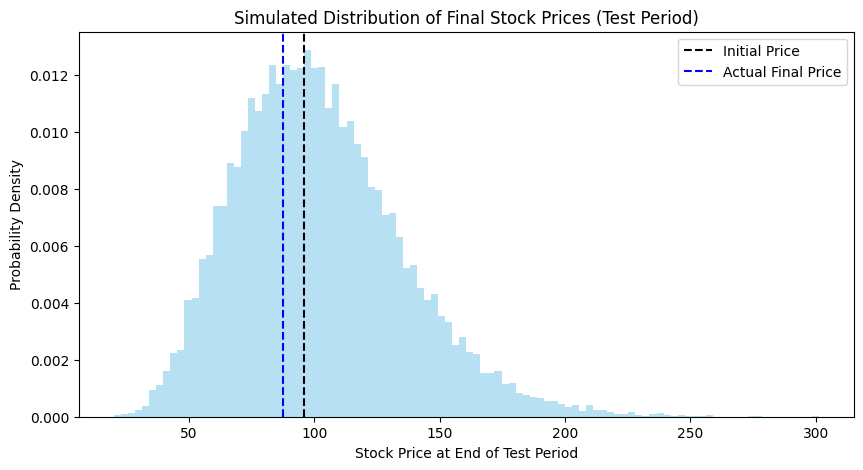

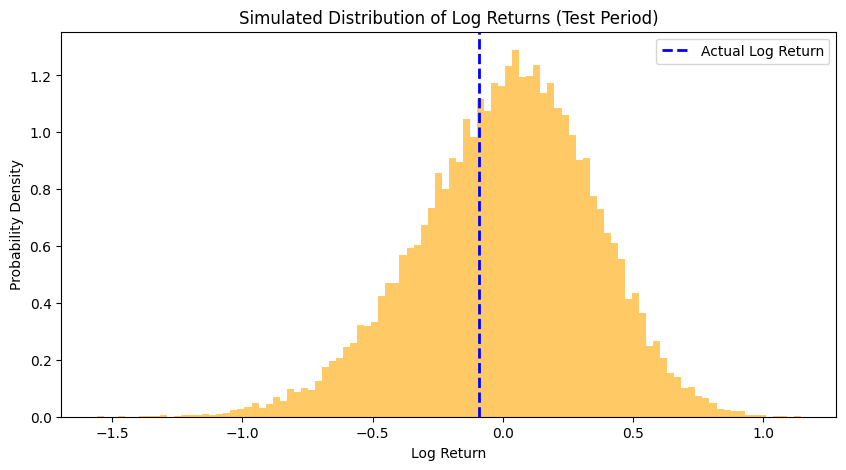

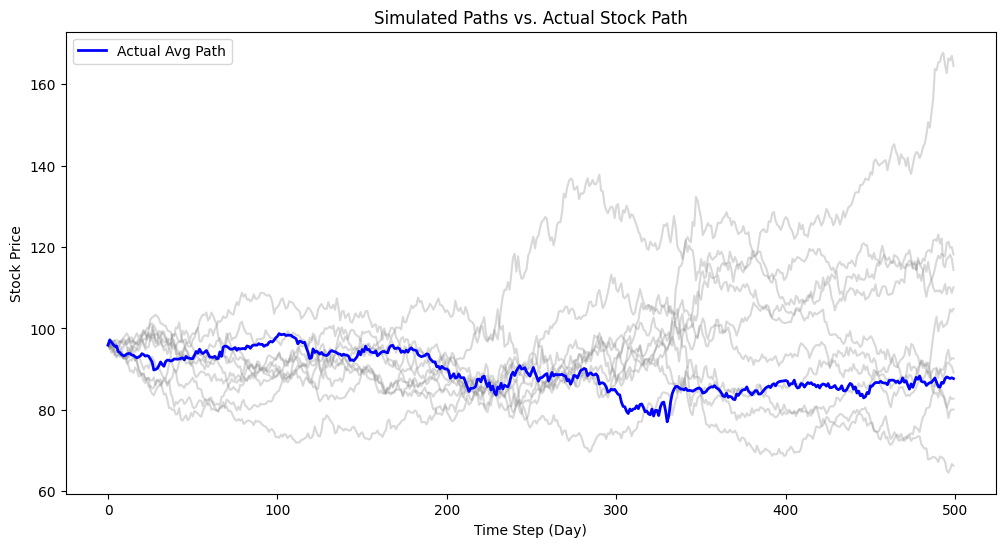

Mean Absolute Error: 14.522309598109416


In [20]:
#visualize price distribution
plt.figure(figsize=(10, 5))
plt.hist(final_prices, bins=100, density=True, alpha=0.6, color='skyblue')
plt.axvline(stock_price, color='black', linestyle='--', label='Initial Price')
plt.axvline(actual_final_price, color='blue', linestyle='--', label='Actual Final Price')
plt.title("Simulated Distribution of Final Stock Prices (Test Period)")
plt.xlabel("Stock Price at End of Test Period")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

#visualize returns distribution
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=100, density=True, alpha=0.6, color='orange')
plt.axvline(actual_log_return, color='blue', linestyle='--', linewidth=2, label='Actual Log Return')
plt.title("Simulated Distribution of Log Returns (Test Period)")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Plot a few simulated paths
plt.figure(figsize=(12,6))
for i in range(10):  # plot 10 simulations
    rand_num = np.random.randint(low=1,high=500)
    plt.plot(price_paths[-rand_num], color='gray', alpha=0.3)

plt.plot(actual_path, color='blue', linewidth=2, label='Actual Avg Path')
plt.title("Simulated Paths vs. Actual Stock Path")
plt.xlabel("Time Step (Day)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#get some metrics to compare closer
#find error of each model between actual data's final price and simulated data's average of the final prices
mae = np.abs(actual_final_price - np.mean(final_prices))
print(f"Mean Absolute Error: {mae}")